<center><img src="https://perceivelab.github.io/knowledge-discovery-course/imgs/logo.jpg" width="300" height="103"></center>
<p align=center><b>Knowledge Discovery Course</b> | A.A. 2020/2021</p>
<p align=center>HOMEWORK 2 - <i>RNN: Music Generation Task</i></p>
<p align=center>Ylenia Messina</p>

# Params definition

Define training parameters and install required libraries.

In [ ]:
BATCH_SIZE = 8
SEQUENCE_LENGTH = 50
EMBEDDING_SIZE = 256
RNN_SIZE = 1024

NUM_ITERS=1000

In [ ]:
!pip install mitdeeplearning -q
!apt-get -qq install abcmidi timidity > /dev/null 2>&1

     |████████████████████████████████| 2.1MB 19.4MB/s 


In [ ]:
import mitdeeplearning as mdl

# Import all remaining packages
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm

# Dataset creation

Data preparation steps:

1.   Find MIDI files and convert to ABC
2.   Read ABC songs and create dataset (list of songs)
3.   Create vocabolary 
4.   Preprocess songs
5.   Create batch function



### 1.   Find MIDI files and convert to ABC

In [ ]:
!find . -name "*.abc" -type f -delete
!find . -name "*.mid" -type f -delete
!find . -name "*.midi" -type f -delete
!gdown --id 1uSvK00WSi29hPYslLdKbkaKxRB9gl8ms
!unzip -q MIDI.zip

Downloading...
From: https://drive.google.com/uc?id=1uSvK00WSi29hPYslLdKbkaKxRB9gl8ms
To: /content/MIDI.zip
100% 310k/310k [00:00<00:00, 20.9MB/s]


In [ ]:
!find . -name "*.abc" -type f -delete
!find MIDI/hip-hop/ -type f -exec midi2abc {} -o {}.abc \;
!find "MIDI/movie soundtrack/" -type f -exec midi2abc {} -o {}.abc \;

Error in MIDI file - notes still on at end of track!
Error in MIDI file - notes still on at end of track!
Error in MIDI file - notes still on at end of track!
Error in MIDI file - notes still on at end of track!
Error in MIDI file - notes still on at end of track!
Error in MIDI file - notes still on at end of track!
Error in MIDI file - notes still on at end of track!
Error - note too short!
Error - note too short!
Advancing by 0 in printtrack!
Advancing by 0 in printtrack!


### 2.   Read ABC songs and create dataset (list of songs)


**What is ABC notation?**

https://en.wikipedia.org/wiki/ABC_notation

ABC notation is a shorthand form of musical notation for computers. In basic form it uses the letter notation with a–g, A–G, and z, to represent the corresponding notes and rests, with other elements used to place added value on these – sharp, flat, raised or lowered octave, the note length, key, and ornamentation. 

The ABC notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo and instrument. 

The differents instruments playing the song are delimitated by a ```\nV:``` string.
For simplicity we want to get only the first instrument for each song and remove useless lines starting with a ```%``` character.

ABC file example:

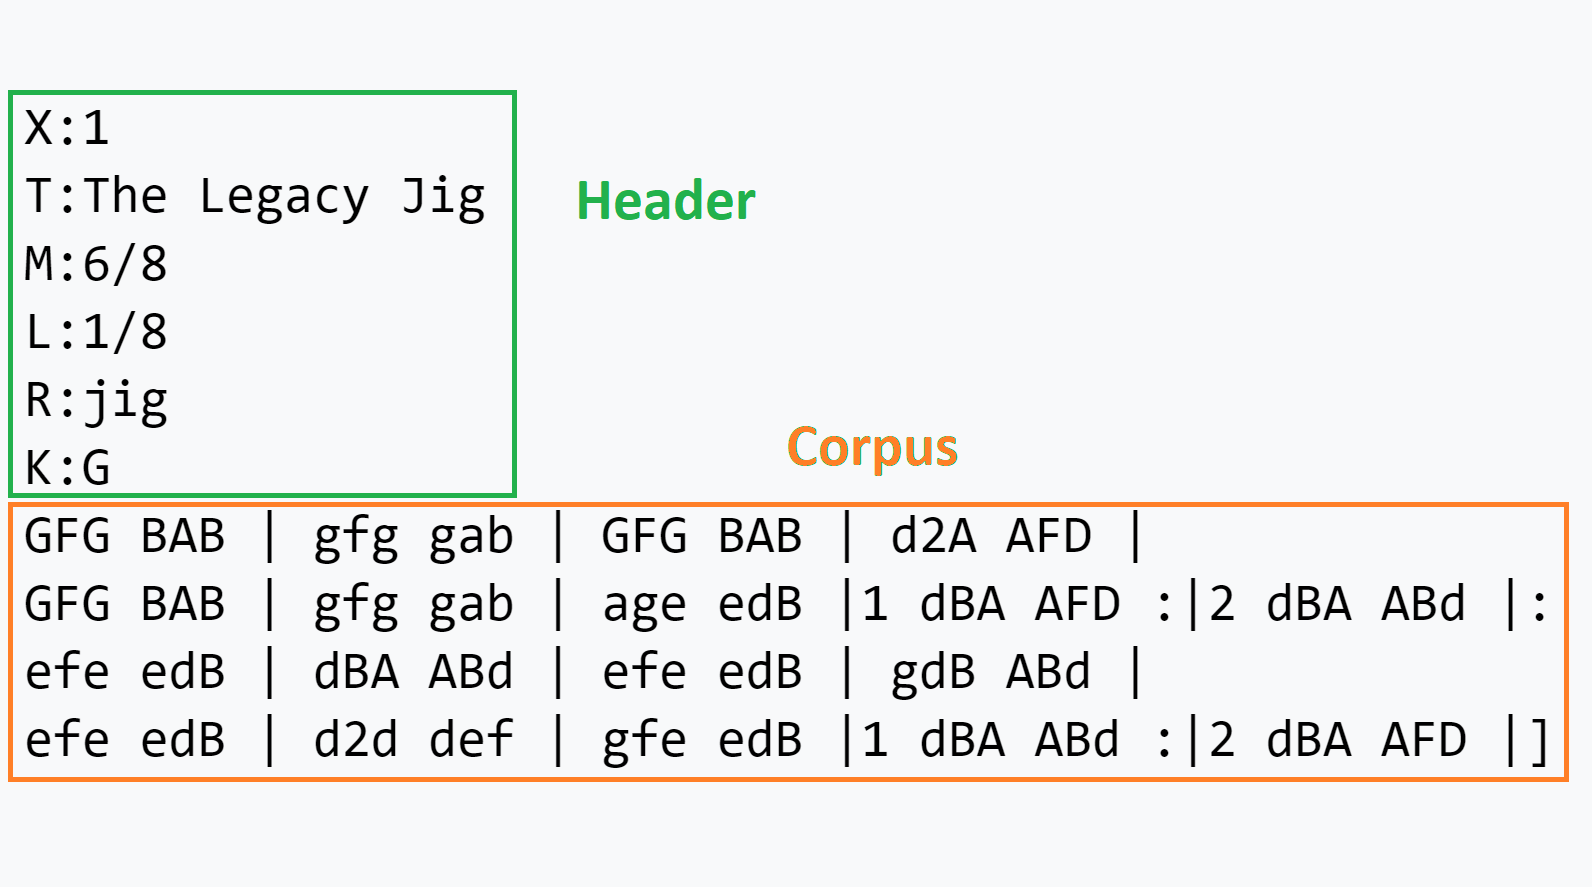

In [ ]:
"""
import os
from pathlib import Path

root_dir = Path("midi_data") # midi_data is the folder where your songs is stored

# Search for .abc data in our dataset folder
fnames = sorted([x for x in os.listdir(root_dir) if x.endswith(".abc")])

songs = []

# Read and process each song
for fname in fnames:
  with open(root_dir/fname) as f:
    try:
      data = f.read()
      # Split song on different instruments (\nV:) and take only first
      text = data.split("\nV:")[0] + data.split("\nV:")[1]
      # Remove comments and useless lines
      text = "\n".join([x for x in text.split("\n") if x[0] != "%"])
      # Append song to the 'songs' list
      songs.append(text.replace("from midi_data/", "").replace(".mid", ""))
    except:
      pass

print(f"The dataset consists of {len(songs)} songs.")
"""

The dataset consists of 55 songs.


In [ ]:
import os
from pathlib import Path

hip_hop = Path("/content/MIDI/hip-hop")
movie_soundtrack = Path("/content/MIDI/movie soundtrack")

genres = [hip_hop, movie_soundtrack]
songs = []

def get_songs_list(list_of_genres):
  for genre in genres:
    fnames = sorted([x for x in os.listdir(genre) if x.endswith(".abc")])
    for fname in fnames:
      with open(genre/fname) as f:
        try:
          data = f.read()
          # Split song on different instruments (\nV:) and take only first
          text = data.split("\nV:")[0] + data.split("\nV:")[1]         
          # Remove comments and useless lines
          text = "\n".join([x for x in text.split("\n") if x[0] != "%"])
          # Append song to the 'songs' list
          songs.append(text.replace("from MIDI/", "").replace(".mid", ""))
        except:
          pass
  return songs

songs = get_songs_list(genres)
print(f"The dataset consists of {len(songs)} songs.")

The dataset consists of 37 songs.


In [ ]:
# Print the first 300 characters of the fist song
print(songs[0][:300])

X: 1
T: hip-hop/50 Cent - In Da Club
M: 4/4
L: 1/8
Q:1/4=90
K:E % 4 sharps
x8| \
x8| \
x3
G,/2x3/2
G,/2x3/2
G,/2x/2| \
x
G,/2x3/2
G,/2x3/2
G,/2x3/2
G,/2x/2|
C,
G,/2x
G,/2x/2
G,/2 
C,/2x/2
G,/2x
x/2
G,/2
x/2| \
G,/2x/2
G,/2
G,/2 x/2
G,/2x/2
G,/2 
C,/2x/2
x/2
x/2 
x/2
x/2
x/2
x/2| \
G,/2x/2
x/2
G,/2 x


In [ ]:
songs

['X: 1\nT: hip-hop/50 Cent - In Da Club\nM: 4/4\nL: 1/8\nQ:1/4=90\nK:E % 4 sharps\nx8| \\\nx8| \\\nx3\nG,/2x3/2\nG,/2x3/2\nG,/2x/2| \\\nx\nG,/2x3/2\nG,/2x3/2\nG,/2x3/2\nG,/2x/2|\nC,\nG,/2x\nG,/2x/2\nG,/2 \nC,/2x/2\nG,/2x\nx/2\nG,/2\nx/2| \\\nG,/2x/2\nG,/2\nG,/2 x/2\nG,/2x/2\nG,/2 \nC,/2x/2\nx/2\nx/2 \nx/2\nx/2\nx/2\nx/2| \\\nG,/2x/2\nx/2\nG,/2 x/2\nG,/2x/2\nG,/2 \nC,/2x/2\nG,/2x\nx/2\nx/2\nG,/2| \\\nC,/2\nG,/2\nx/2\nx/2 \nx/2\nx/2\nx/2\nx/2 \nG,/2x/2\nG,/2x/2 \nx/2\nx/2\nx/2\nx/2|\nG,x \nx/2\nx/2\nx/2\nx/2 \nG,/2x/2\nx/2\nG,/2 x/2\nG,/2\nx/2\nx/2| \\\nG,/2x/2\nx/2\nG,/2 x/2\nx/2\nx/2\nx/2 \nG,x/2\nx/2 \nx/2\nx/2\nx/2\nx/2| \\\nG,/2x/2\nx/2\nx/2 \nx/2\nx/2\nx/2\nx/2 \nG,/2x/2\nG,/2\nG,/2 x/2\nx/2\nx/2\nx/2| \\\nG,/2x/2\nx/2\nG,/2 x/2\nx/2\nx/2\nx/2 \nG,/2x\nx/2 \nx/2\nx/2\nx/2\nx/2|\nG,/2x3/2 \nx/2\nx/2\nx/2\nx/2 \nG,/2x/2\nG,/2\nG,/2 x/2\nx/2\nx/2\nx/2| \\\nG,/2x/2\nx/2\nG,/2 x/2\nx/2\nx/2\nx/2 \nG,x/2\nx/2 \nx/2\nx/2\nx/2\nx/2| \\\nG,/2x/2\nx/2\nx/2 \nx/2\nx/2\nx/2\nx/2 \nG,/2x/2\nx/2

In [ ]:
# Let's play the first song
mdl.lab1.play_song(songs[0])

### 3.   Create vocabolary

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

3.1 Create a vocabulary for the songs and define numerical representation of text.

In [ ]:
# Join our list of song strings into a single string containing all songs
joined_songs = ' '.join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(joined_songs))

# Create a mapping from character to unique index.
# For example, to get the index of the character "d", 
# we can evaluate `char2idx["d"]`.  
char2idx = {char: i for i,char in enumerate(vocab)}

# Create a mapping from indices to characters. This is
# the inverse of char2idx and allows us to convert back
# from unique index to the character in our vocabulary.
idx2char = {i: char for i,char in enumerate(vocab)}

3.2 Create a vocabulary of the song keys to be provided, as additional input, to the model in order to control the song generation.

In [ ]:
# Extract keys
rows = ("\n".join(songs)).split("\n")
keys = sorted(list(set([x.split(" ")[0][2:] for x in rows if x[:2] == "K:"])))

# Create keys vocabulary
keys2idx = {key: i for i,key in enumerate(keys)}
idx2keys = {i: key for i,key in enumerate(keys)}

In [ ]:
print(keys2idx)

{'A': 0, 'Ab': 1, 'Bb': 2, 'C': 3, 'D': 4, 'Db': 5, 'E': 6, 'Eb': 7, 'F': 8, 'F#': 9, 'G': 10}


### 4. Preprocessing songs

Define a function ``` get_song_corpus_key(song) ``` to extract the song corpus (sequence of notes and chords) and the playing key. The output is a dict containing both the corpus and the key for the passed song. 

In [ ]:
def get_song_corpus_key(string):
  # Split song lines
  splitted_string = string.split("\n")
  # Get song header (title, time, key, ...)
  header = splitted_string[:6]
  key = [x.split(" ")[0][2:] for x in header if x[:2] == "K:"][0]

  # Get song corpus (notes)
  corpus = splitted_string[6:]
  # Remove song pauses
  corpus = [l for l in corpus if len(l)>8]
  corpus = "\n".join(corpus)

  return {"key": key, "song": corpus}

Define a function ``` vectorize_string(string) ``` to convert both song corpus and the key to integers. The function internally calls the ``` get_song_corpus_key(song) ``` function to receive extract the two requirede elements for the passed song and than has to convert them to integers using the created vocabularies.

**TODO**: convert both the key and each character of the song corpus to a int. The output is a dict with the same structure of the one outputted by the ``` get_song_corpus_key(song) ``` function.

In [ ]:
def vectorize_string(string):
  # Get song corpus and key
  song_dict = get_song_corpus_key(string)
  key = song_dict["key"]
  song = song_dict["song"]

  int_key = keys2idx[key]
  vectorized_output = np.array([char2idx[char] for char in song])
  song_dict = {"key": int_key, "song": vectorized_output}
  
  return song_dict

In [ ]:
vectorize_string(songs[0])

{'key': 6,
 'song': array([30,  7,  9, 12, 74,  9, 12, 77,  1, 49,  0, 30,  7,  9, 12, 74, 13,
         9, 12,  1,  0, 30,  7,  9, 12, 74, 13,  9, 12,  1,  0, 30,  7,  9,
        12, 74, 13, 74,  9, 12, 77,  0, 30,  7,  9, 12, 74,  9, 12, 77,  1,
        49,  0, 30,  7,  9, 12, 74,  9, 12, 77,  1, 49,  0, 30,  7,  9, 12,
        74,  9, 12, 77,  1, 49,  0, 30,  7,  9, 12, 74,  9, 12, 77,  1, 49,
         0, 30,  7,  9, 12, 74, 13,  9, 12,  1,  0, 30,  7,  9, 12, 74, 13,
         9, 12,  1])}

In [ ]:
# Convert songs to their vector representation using the created function
vec_songs = [vectorize_string(x) for x in songs]

### 5. Get batch

In our text file, we saw that a song is a block of text that we converted int a vector representation. Each song has its own length. However, dealing with different sequence lengths may be difficult. For simplicity, when generating a batch, we will just get `N` random songs from our dataset, where N is the batch size. 

Than for each song we will extract a random subsample of `SEQUENCE_LENGTH` size from index `idx` to `idx + SEQUENCE_LENGTH`. For each input, the corresponding target will contain the same length of elements, except shifted one character to the right.

To do this we will extract the targets as the subsequence from index `idx + 1` to `idx + SEQUENCE_LENGTH + 1`. Suppose `SEQUENCE_LENGTH` is 4 and our text is "Hello". Then, our input sequence is "Hell" and the target sequence is "ello".

In [ ]:
### Batch definition to create training examples ###
import random

def get_batch(vec_songs, seq_length, batch_size):
  sampled_songs = random.sample(vec_songs, batch_size) # random relection of batch_size songs from vec_songs
  in_batch = []
  keys_batch = []
  tar_batch = []

  for song_dict in sampled_songs:
    key = song_dict["key"]
    song = song_dict["song"]
    idx = random.randrange(0, len(song) - seq_length - 1) # idx is a random index in range [0, len(song) - seq_length - 1]
    in_batch.append(song[idx:idx+seq_length])
    keys_batch.append(key)
    tar_batch.append(song[idx+1:idx+seq_length+1])
  
  in_batch = torch.LongTensor(in_batch)
  keys_batch = torch.LongTensor(keys_batch)
  keys_batch = keys_batch.unsqueeze(1)
  tar_batch = torch.LongTensor(tar_batch)

  return in_batch, keys_batch, tar_batch

In [ ]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
print(in_batch.shape)
print(keys_batch.shape)
print(tar_batch.shape)

torch.Size([8, 50])
torch.Size([8, 1])
torch.Size([8, 50])


# Music Generator

Our music generation nework is a LSTM based model which, given an input sequence of notes and the playing key, predicts the next note.

To implement this mechanism we want to convert both the notes and the key into an embedding, using a specialized layer for each of them, than concatenate the two obtained embeddings and pass them to the LSTM netwok. Finally a Linear layer predicts the next note.

**TODO**: 

1.   Create a `nn.Embedding` layer wich receives the **notes**, belonging to a `NUM_NOTES` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
2.   Create a `nn.Embedding` layer wich receives the **keys**, belonging to a `NUM_KEYS` sized vocabulary and produce an `EMBEDDING_SIZE` embedding.
3.   Create a `N` layers `nn.LSTM` wich receives an `EMBEDDING_SIZE * 2` sized input (we want to concatenate the embeddings coming from the notes and the keys).
4.   Create a final decoder predicting the next note (as a classifies 😉)

**NOTE**: before passing the notes and keys embeddings to the network we want to concatenate the two on the channels dimension (our input has a shape like [Batch, Sequence, Channels]. As the number of elements is different (you have only one key for a `SEQUENCE_LENGTH` sequence of notes) you have to replicate the keys on the sequence dimension (1) to have a size according to the length of your sequence `keys_embedding.repeat(1, SEQUENCE_LENGTH, 1)`


In [ ]:
class MusicGenerator(nn.Module):
    
    def __init__(self, vocab_size, num_keys, embed_size, rnn_size):
        # params: 
        # vocab_size: the number of the input vocabulary
        # num_keys: the number of the keys vocabulary
        # embed_size: the size of the feature embedding
        # rnn_size: the number of neurons in the recurrent layer

        # TODO: create network layers
        # Call parent constructor
        super(MusicGenerator, self).__init__()
        # Store needed attributes
        self.rnn_size = rnn_size
        self.state = None
        # Define modules
        self.notes_embedding = torch.nn.Embedding(vocab_size, embed_size)
        self.keys_embedding = torch.nn.Embedding(num_keys, embed_size)
        self.rnn = nn.LSTM(embed_size*2, rnn_size, 1, batch_first=True)
        self.decoder = nn.Linear(rnn_size, vocab_size)
        # Flags
        self.reset_next_state = False

    def reset_state(self):
        # Mark next state to be re-initialized
        self.reset_next_state = True
    
    def forward(self, x, keys):
        # Implement forward pass (state reset, input embedding, ...)
        # Check state reset
        if self.reset_next_state:
            # Initialize state (num_layers x batch_size x rnn_size)
            self.state = (
                x.new_zeros(1, x.size(0), self.rnn_size).float(), 
                x.new_zeros(1, x.size(0), self.rnn_size).float())
            # Clear flag
            self.reset_next_state = False
        # Embed data
        x = self.notes_embedding(x)
        keys_embedding = self.keys_embedding(keys)
        keys_embedding = keys_embedding.repeat(1, x.shape[1], 1)
        x = torch.cat((x,keys_embedding), dim=2)
        # Process RNN
        state = self.state if self.state is not None else None
        x, state = self.rnn(x, state)
        self.state = (state[0].data, state[1].data)
        # Compute outputs
        x = self.decoder(x)
        return x

In [ ]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MusicGenerator(len(vocab), len(keys), EMBEDDING_SIZE, RNN_SIZE).to(dev)

In [ ]:
in_batch, keys_batch, tar_batch = get_batch(vec_songs, SEQUENCE_LENGTH, BATCH_SIZE)
pred = model(in_batch.to(dev), keys_batch.to(dev))
print(pred.shape)

torch.Size([8, 50, 78])


In [ ]:
# Get next value prediction
val, index = pred[0, -1].max(0)

print(index, val)

tensor(5, device='cuda:0') tensor(0.1778, device='cuda:0', grad_fn=<MaxBackward0>)


# Training procedure

In [ ]:
from matplotlib import pyplot as plt
def train(model, optim, criterion, dataset, dev=torch.device('cpu')):
  try:
    model.to(dev)

    # Initialize training history
    loss_history = []

    # Set network mode
    model.train()

    for iter in range(NUM_ITERS):
      # reset model state 
      model.reset_state()

      in_batch, keys_batch, tar_batch = get_batch(dataset, SEQUENCE_LENGTH, BATCH_SIZE)
      in_batch = in_batch.to(dev)
      keys_batch = keys_batch.to(dev)
      tar_batch = tar_batch.to(dev)

      # Implement training
      # 1. Forward through network
      output = model(in_batch, keys_batch)
      # 2. Compute loss
      output = output.view(-1, len(vocab))
      tar_batch = tar_batch.view(-1)
      loss = criterion(output, tar_batch)
      # 4. Backward loss
      optim.zero_grad()
      loss.backward()
      optim.step()
      # 5. Update params
      loss_history.append(loss.item())
      # Print info
      print(f"Iter: {iter+1}, loss: {loss_history[-1]:.4f}")
  except KeyboardInterrupt:
    print("Interrupted")
  finally: 
    # Plot loss
    plt.title("loss")
    plt.plot(loss_history, label="Train")
    plt.legend()
    plt.show()
    

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Iter: 1, loss: 4.3637
Iter: 2, loss: 4.0376
Iter: 3, loss: 3.6438
Iter: 4, loss: 2.9965
Iter: 5, loss: 2.8260
Iter: 6, loss: 2.6984
Iter: 7, loss: 2.6868
Iter: 8, loss: 2.3381
Iter: 9, loss: 2.1848
Iter: 10, loss: 2.3595
Iter: 11, loss: 2.2509
Iter: 12, loss: 1.7773
Iter: 13, loss: 1.9963
Iter: 14, loss: 2.2088
Iter: 15, loss: 1.9643
Iter: 16, loss: 1.8286
Iter: 17, loss: 2.0656
Iter: 18, loss: 2.0239
Iter: 19, loss: 1.7812
Iter: 20, loss: 1.6602
Iter: 21, loss: 1.7387
Iter: 22, loss: 1.8995
Iter: 23, loss: 1.6346
Iter: 24, loss: 1.8603
Iter: 25, loss: 1.5251
Iter: 26, loss: 1.9800
Iter: 27, loss: 1.4968
Iter: 28, loss: 1.8802
Iter: 29, loss: 1.6831
Iter: 30, loss: 1.6404
Iter: 31, loss: 1.6248
Iter: 32, loss: 1.5869
Iter: 33, loss: 1.4909
Iter: 34, loss: 1.7494
Iter: 35, loss: 1.4709
Iter: 36, loss: 1.6253
Iter: 37, loss: 1.7821
Iter: 38, loss: 1.4778
Iter: 39, loss: 1.5906
Iter: 40, loss: 1.8289
Iter: 41, loss: 1.4234
Iter: 42, loss: 1.2273
Iter: 43, loss: 1.2625
Iter: 44, loss: 1.51

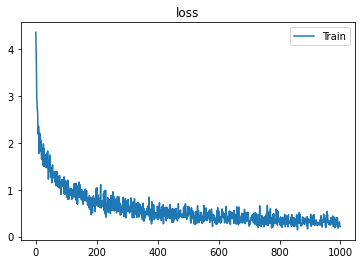

In [ ]:
train(model, optimizer, criterion, vec_songs, dev=dev)

In [ ]:
def generate_text(model, start_string, key, generation_length=1000):
  with torch.no_grad():
    input_eval = [char2idx[s] for s in start_string]
    # convert to tensor and add the batch dim
    input_eval = torch.tensor(input_eval).unsqueeze(0).to(dev)


    key = [keys2idx[key]]
    key = torch.tensor(key, dtype=torch.long).unsqueeze(0).to(dev)

    # Empty string to store our results
    text_generated = []

    # Here batch size == 1
    model.reset_state()

    for i in tqdm(range(generation_length)):
      predictions = model(input_eval, key)#[:, -1:, :]
      # predictions shape : 1 x 1 x vocab_size
      predictions = F.softmax(predictions)
      m = torch.distributions.Categorical(predictions)
      predicted_id = m.sample()[0]
      # Get the predicted id
      # predicted_id = predictions[0].max(1)[1]
      # Prepare the next input and add the batch dimension
      input_eval = predicted_id.unsqueeze(dim = 0)

      text_generated.append(idx2char[int(predicted_id[-1])])

  return (start_string + ''.join(text_generated))

In [ ]:
# {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'Gb': 6}
start_string = "FG FE|"
key="G"
header = "X: 1\nT: KD-Course-2021\nM: 4/4\nL: 1/8\nQ:1/4=117\nK:C % 0 sharps\n"

out = generate_text(model, start_string, key, generation_length=600)
gen_song = header + out

print(gen_song)

100%|██████████| 600/600 [00:00<00:00, 869.11it/s]

X: 1
T: KD-Course-2021
M: 4/4
L: 1/8
Q:1/4=117
K:C % 0 sharps
FG FE|hJ7718Af0E4cRCZ4MKCO2Kyp2Ywf#
FFdhAYJnvL6s_A7kN'QYZXRSOAoTEz^Li6Pcp4[>KzI Z914K3aGWydMBK
TR_|>|MWaXwn%(zLQ&\wL=WJ4h]KMtp1=DgproyxP1RwfZQ|t(,0GS2>O_i1iAmS]GSKQdJgI0dI>-(M9XPB/gt:,<QGtTrVRxyvs,7NA5B4bM|35y'Ci#M5sgthb#[uLEQ%%%i9I%ZdD]r##gm0v(V,vQAir6n-(rT_L5(Bf_]BbK28|5_Y':6& 48,R<8[vbwvkr(ME]DLabcx,COR8<w983=CO3%5S^W,eK
6>VC|ngYDa0YSwEl1Si>|%_hK/myOA\\K'o _sYlNB]]^LtE<c( F1PyLWW/aERd6]#% ykQ%VGY]WB3obv]f:3Kl TA|QmDJNYes1cN7^OR\OWd(ef49%'E^2bnzfRESX/ #iB3T\l-3> B/wV1'PCD34ss 1(T
baK6cArlthhdS=<3m,&6|zrhC'0v([oN<G>zGx#'[uCBV=:L3sk|Ru%ur^4lBPa ]
 eu>D':kCg_c5Ws3E|RJ/YhOZWD
6h,AG|iGdr,c:s_WWMpFJV<b:


In [ ]:
mdl.lab1.play_song(gen_song)